In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from material_models import Fung, GOH, MR, HGO
from NODE_fns import NODE_sigma_vmap
import pickle
import pandas as pd

In [2]:
trn = pd.DataFrame(index=['Off-x', 'Off-y', 'Equibiaxial', 'Strip-x', 'Strip-y'], 
                   columns=['GOH Mean', 'GOH Median', 'MR Mean', 'MR Median', 
                            'HGO Mean', 'HGO Median', 'Fung Mean', 'Fung Median', 'NN Mean', 'NN Median'])
val = pd.DataFrame(index=['Off-x', 'Off-y', 'Equibiaxial', 'Strip-x', 'Strip-y'], 
                   columns=['GOH Mean', 'GOH Median', 'MR Mean', 'MR Median', 
                            'HGO Mean', 'HGO Median', 'Fung Mean', 'Fung Median', 'NN Mean', 'NN Median'])
def update_table(n_trn, row):
    trn.at[row, 'NN Mean']     = np.mean(NN_e[:n_trn])
    trn.at[row, 'NN Median']   = np.median(NN_e[:n_trn])
    trn.at[row, 'GOH Mean']    = np.mean(GOH_e[:n_trn])
    trn.at[row, 'GOH Median']  = np.median(GOH_e[:n_trn])
    trn.at[row, 'MR Mean']     = np.mean(MR_e[:n_trn])
    trn.at[row, 'MR Median']   = np.median(MR_e[:n_trn])
    trn.at[row, 'HGO Mean']    = np.mean(HGO_e[:n_trn])
    trn.at[row, 'HGO Median']  = np.median(HGO_e[:n_trn])
    trn.at[row, 'Fung Mean']   = np.mean(Fung_e[:n_trn])
    trn.at[row, 'Fung Median'] = np.median(Fung_e[:n_trn])

    val.at[row, 'NN Mean']     = np.mean(NN_e[n_trn:])
    val.at[row, 'NN Median']   = np.median(NN_e[n_trn:])
    val.at[row, 'GOH Mean']    = np.mean(GOH_e[n_trn:])
    val.at[row, 'GOH Median']  = np.median(GOH_e[n_trn:])
    val.at[row, 'MR Mean']     = np.mean(MR_e[n_trn:])
    val.at[row, 'MR Median']   = np.median(MR_e[n_trn:])
    val.at[row, 'HGO Mean']    = np.mean(HGO_e[n_trn:])
    val.at[row, 'HGO Median']  = np.median(HGO_e[n_trn:])
    val.at[row, 'Fung Mean']   = np.mean(Fung_e[n_trn:])
    val.at[row, 'Fung Median'] = np.median(Fung_e[n_trn:])

def plot_stress():
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(lm_exp[:,0], sigma_exp[:,0],'o',label='Experimental')
    ax1.plot(lm_exp[:,0], sigma_GOH[:,0,0],label='GOH')
    ax1.plot(lm_exp[:,0], sigma_MR[:,0,0],label='MR')
    ax1.plot(lm_exp[:,0], sigma_HGO[:,0,0],label='HGO')
    ax1.plot(lm_exp[:,0], sigma_Fung[:,0,0],label='Fung')
    ax1.plot(lm_exp[:,0], sigma_NN[:,0,0],label='NODE',c='k', linestyle='--')
    ax1.legend()
    ax1.set_title('$\sigma_{xx}$')
    
    ax2.plot(lm_exp[:,1], sigma_exp[:,1],'o')
    ax2.plot(lm_exp[:,1], sigma_GOH[:,1,1],label='GOH')
    ax2.plot(lm_exp[:,1], sigma_MR[:,1,1],label='MR')
    ax2.plot(lm_exp[:,1], sigma_HGO[:,1,1],label='HGO')
    ax2.plot(lm_exp[:,1], sigma_Fung[:,1,1],label='Fung')
    ax2.plot(lm_exp[:,1], sigma_NN[:,1,1],label='NODE',c='k', linestyle='--')
    #ax2.legend()
    ax2.set_title('$\sigma_{yy}$')

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


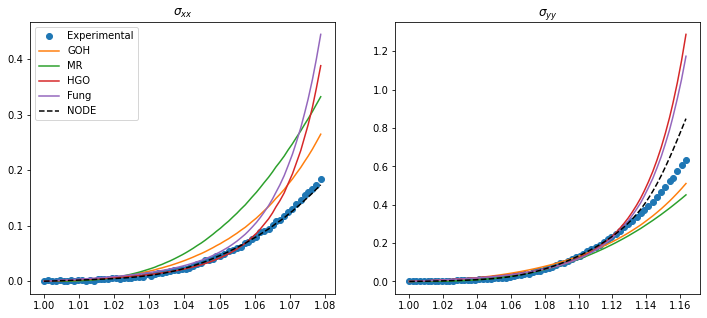

In [3]:
# Off-x
# Load experimental data
dataset_name = 'P12AC1_x80'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_trn, sigma_trn = np.load(f,allow_pickle=True)
lm1 = lm_trn[:,0]
lm2 = lm_trn[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_trn = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

dataset_name = 'P12AC1_x20'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_val, sigma_val = np.load(f,allow_pickle=True)
lm1 = lm_val[:,0]
lm2 = lm_val[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_val = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

sigma_exp = np.vstack((sigma_trn, sigma_val))
lm_exp = np.vstack((lm_trn, lm_val))
F_exp = np.vstack((F_trn, F_val))



# Load models
with open('savednet/P12AC1_x80.npy', 'rb') as f:
    NODE_params = pickle.load(f)
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)

#Fits on 80% of off-x
GOH_params  = [ 0.        ,  8.04132162, 65.30923597,  0.31029252,  1.57013876]
MR_params   = [0.        , 0.        , 1.03095594]
HGO_params  = [ 0.        ,  0.07173115, 29.02990043,  1.03628853]
Fung_params = [3.88210473e-03, 0.00000000e+00, 1.00000000e+01, 8.79021254e+01]

sigma_GOH   = GOH(GOH_params).sigma(lm_exp)
sigma_MR    = MR(MR_params).sigma(lm_exp)
sigma_HGO   = HGO(HGO_params).sigma(lm_exp)
sigma_Fung  = Fung(Fung_params).sigma(lm_exp)

sigma_mp_exp  = np.max(sigma_exp,  axis=1)
sigma_mp_NN   = np.max(sigma_NN,   axis=(1,2))
sigma_mp_GOH  = np.max(sigma_GOH,  axis=(1,2))
sigma_mp_MR   = np.max(sigma_MR,   axis=(1,2))
sigma_mp_HGO  = np.max(sigma_HGO,  axis=(1,2))
sigma_mp_Fung = np.max(sigma_Fung, axis=(1,2))

NN_e   = np.abs(sigma_mp_NN   - sigma_mp_exp)
GOH_e  = np.abs(sigma_mp_GOH  - sigma_mp_exp)
MR_e   = np.abs(sigma_mp_MR   - sigma_mp_exp)
HGO_e  = np.abs(sigma_mp_HGO  - sigma_mp_exp)
Fung_e = np.abs(sigma_mp_Fung - sigma_mp_exp)

n_trn = sigma_trn.shape[0]
update_table(n_trn, 'Off-x')
plot_stress()

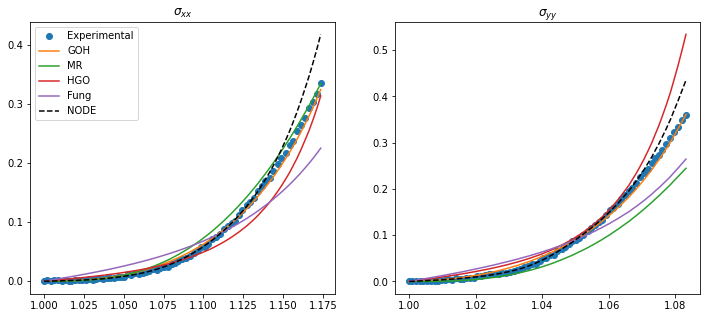

In [4]:
# Off-y
# Load experimental data
dataset_name = 'P12AC1_y80'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_trn, sigma_trn = np.load(f,allow_pickle=True)
lm1 = lm_trn[:,0]
lm2 = lm_trn[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_trn = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

dataset_name = 'P12AC1_y20'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_val, sigma_val = np.load(f,allow_pickle=True)
lm1 = lm_val[:,0]
lm2 = lm_val[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_val = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

sigma_exp = np.vstack((sigma_trn, sigma_val))
lm_exp = np.vstack((lm_trn, lm_val))
F_exp = np.vstack((F_trn, F_val))



# Load models
with open('savednet/P12AC1_y80.npy', 'rb') as f:
    NODE_params = pickle.load(f)
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)

#Fits on 80% of off-y
GOH_params  = [ 0.        ,  8.04202335, 65.30924669,  0.30800452,  1.5701411 ]
MR_params   = [3.30337917e-06, 0.00000000e+00, 6.50994105e-01]
HGO_params  = [ 0.        ,  0.13033467, 29.0309185 ,  0.95515042]
Fung_params = [ 0.03984016,  0.50664212, 10.        , 10.53688994]

sigma_GOH   = GOH(GOH_params).sigma(lm_exp)
sigma_MR    = MR(MR_params).sigma(lm_exp)
sigma_HGO   = HGO(HGO_params).sigma(lm_exp)
sigma_Fung  = Fung(Fung_params).sigma(lm_exp)

sigma_mp_exp  = np.max(sigma_exp,  axis=1)
sigma_mp_NN   = np.max(sigma_NN,   axis=(1,2))
sigma_mp_GOH  = np.max(sigma_GOH,  axis=(1,2))
sigma_mp_MR   = np.max(sigma_MR,   axis=(1,2))
sigma_mp_HGO  = np.max(sigma_HGO,  axis=(1,2))
sigma_mp_Fung = np.max(sigma_Fung, axis=(1,2))

NN_e   = np.abs(sigma_mp_NN   - sigma_mp_exp)
GOH_e  = np.abs(sigma_mp_GOH  - sigma_mp_exp)
MR_e   = np.abs(sigma_mp_MR   - sigma_mp_exp)
HGO_e  = np.abs(sigma_mp_HGO  - sigma_mp_exp)
Fung_e = np.abs(sigma_mp_Fung - sigma_mp_exp)

n_trn = sigma_trn.shape[0]
update_table(n_trn, 'Off-y')
plot_stress()

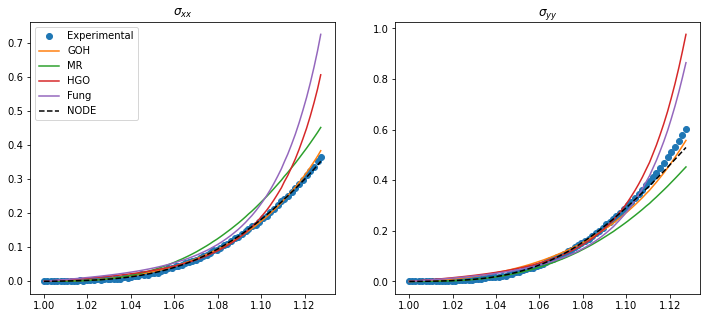

In [5]:
# Equi
# Load experimental data
dataset_name = 'P12AC1_b80'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_trn, sigma_trn = np.load(f,allow_pickle=True)
lm1 = lm_trn[:,0]
lm2 = lm_trn[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_trn = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

dataset_name = 'P12AC1_b20'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_val, sigma_val = np.load(f,allow_pickle=True)
lm1 = lm_val[:,0]
lm2 = lm_val[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_val = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

sigma_exp = np.vstack((sigma_trn, sigma_val))
lm_exp = np.vstack((lm_trn, lm_val))
F_exp = np.vstack((F_trn, F_val))



# Load models
with open('savednet/P12AC1_b80.npy', 'rb') as f:
    NODE_params = pickle.load(f)
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)

#Fits on 80% of Equibiaxial
GOH_params  = [ 0.        , 10.        , 65.39247015,  0.30941134,  1.54501736]
MR_params   = [0.        , 0.        , 1.07448278]
HGO_params  = [ 0.        ,  0.13546485, 29.03150396,  0.90301816]
Fung_params = [9.53498713e-03, 0.00000000e+00, 1.00000000e+01, 5.27591527e+01]

sigma_GOH   = GOH(GOH_params).sigma(lm_exp)
sigma_MR    = MR(MR_params).sigma(lm_exp)
sigma_HGO   = HGO(HGO_params).sigma(lm_exp)
sigma_Fung  = Fung(Fung_params).sigma(lm_exp)

sigma_mp_exp  = np.max(sigma_exp,  axis=1)
sigma_mp_NN   = np.max(sigma_NN,   axis=(1,2))
sigma_mp_GOH  = np.max(sigma_GOH,  axis=(1,2))
sigma_mp_MR   = np.max(sigma_MR,   axis=(1,2))
sigma_mp_HGO  = np.max(sigma_HGO,  axis=(1,2))
sigma_mp_Fung = np.max(sigma_Fung, axis=(1,2))

NN_e   = np.abs(sigma_mp_NN   - sigma_mp_exp)
GOH_e  = np.abs(sigma_mp_GOH  - sigma_mp_exp)
MR_e   = np.abs(sigma_mp_MR   - sigma_mp_exp)
HGO_e  = np.abs(sigma_mp_HGO  - sigma_mp_exp)
Fung_e = np.abs(sigma_mp_Fung - sigma_mp_exp)

n_trn = sigma_trn.shape[0]
update_table(n_trn, 'Equibiaxial')
plot_stress()

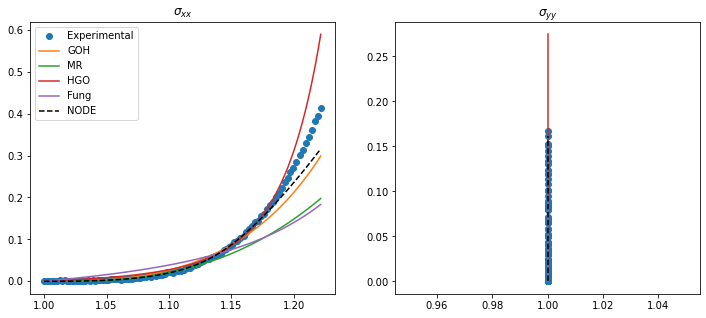

In [6]:
# Strip-x
# Load experimental data
dataset_name = 'P12AC1_sx80'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_trn, sigma_trn = np.load(f,allow_pickle=True)
lm1 = lm_trn[:,0]
lm2 = lm_trn[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_trn = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

dataset_name = 'P12AC1_sx20'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_val, sigma_val = np.load(f,allow_pickle=True)
lm1 = lm_val[:,0]
lm2 = lm_val[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_val = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

sigma_exp = np.vstack((sigma_trn, sigma_val))
lm_exp = np.vstack((lm_trn, lm_val))
F_exp = np.vstack((F_trn, F_val))



# Load models
with open('savednet/P12AC1_sx80.npy', 'rb') as f:
    NODE_params = pickle.load(f)
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)

#Fits on 80% of Strip-x
GOH_params  = [ 0.        ,  8.85821692, 65.31981505,  0.3249001 ,  1.56676331]
MR_params   = [0.        , 0.        , 0.37046013]
HGO_params  = [ 0.        ,  0.04998897, 29.03109316,  0.69496074]
Fung_params = [ 0.02081614,  8.76290964, 10.        , 13.10462568]

sigma_GOH   = GOH(GOH_params).sigma(lm_exp)
sigma_MR    = MR(MR_params).sigma(lm_exp)
sigma_HGO   = HGO(HGO_params).sigma(lm_exp)
sigma_Fung  = Fung(Fung_params).sigma(lm_exp)

sigma_mp_exp  = np.max(sigma_exp,  axis=1)
sigma_mp_NN   = np.max(sigma_NN,   axis=(1,2))
sigma_mp_GOH  = np.max(sigma_GOH,  axis=(1,2))
sigma_mp_MR   = np.max(sigma_MR,   axis=(1,2))
sigma_mp_HGO  = np.max(sigma_HGO,  axis=(1,2))
sigma_mp_Fung = np.max(sigma_Fung, axis=(1,2))

NN_e   = np.abs(sigma_mp_NN   - sigma_mp_exp)
GOH_e  = np.abs(sigma_mp_GOH  - sigma_mp_exp)
MR_e   = np.abs(sigma_mp_MR   - sigma_mp_exp)
HGO_e  = np.abs(sigma_mp_HGO  - sigma_mp_exp)
Fung_e = np.abs(sigma_mp_Fung - sigma_mp_exp)

n_trn = sigma_trn.shape[0]
update_table(n_trn, 'Strip-x')
plot_stress()

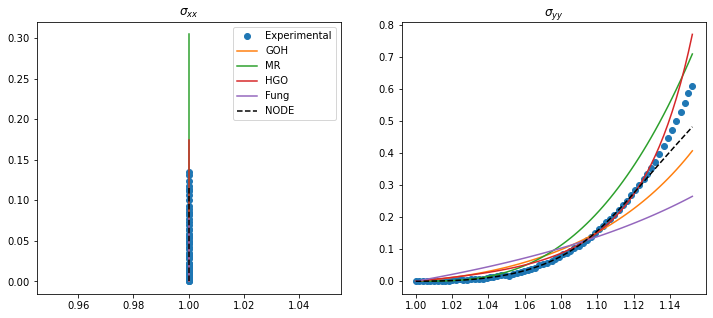

In [7]:
# Strip-y
# Load experimental data
dataset_name = 'P12AC1_sy80'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_trn, sigma_trn = np.load(f,allow_pickle=True)
lm1 = lm_trn[:,0]
lm2 = lm_trn[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_trn = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

dataset_name = 'P12AC1_sy20'
with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lm_val, sigma_val = np.load(f,allow_pickle=True)
lm1 = lm_val[:,0]
lm2 = lm_val[:,1]
lm3 = 1/(lm1*lm2)
zeros = np.zeros(lm1.shape)
F_val = np.array([[lm1, zeros, zeros], [zeros, lm2, zeros], [zeros, zeros, lm3]]).transpose((2,0,1))

sigma_exp = np.vstack((sigma_trn, sigma_val))
lm_exp = np.vstack((lm_trn, lm_val))
F_exp = np.vstack((F_trn, F_val))



# Load models
with open('savednet/P12AC1_sy80.npy', 'rb') as f:
    NODE_params = pickle.load(f)
sigma_NN = NODE_sigma_vmap(F_exp, NODE_params)

#Fits on 80% of Strip-x
GOH_params  = [ 0.        ,  8.04344379, 65.3093073 ,  0.29520379,  1.57011521]
MR_params   = [0.0000000e+00, 7.9150798e-04, 3.7994679e+00]
HGO_params  = [ 0.        ,  0.11839346, 29.03085553,  1.06879191]
Fung_params = [ 0.05806624,  6.73271837, 10.        , 17.46828334]

sigma_GOH   = GOH(GOH_params).sigma(lm_exp)
sigma_MR    = MR(MR_params).sigma(lm_exp)
sigma_HGO   = HGO(HGO_params).sigma(lm_exp)
sigma_Fung  = Fung(Fung_params).sigma(lm_exp)

sigma_mp_exp  = np.max(sigma_exp,  axis=1)
sigma_mp_NN   = np.max(sigma_NN,   axis=(1,2))
sigma_mp_GOH  = np.max(sigma_GOH,  axis=(1,2))
sigma_mp_MR   = np.max(sigma_MR,   axis=(1,2))
sigma_mp_HGO  = np.max(sigma_HGO,  axis=(1,2))
sigma_mp_Fung = np.max(sigma_Fung, axis=(1,2))

NN_e   = np.abs(sigma_mp_NN   - sigma_mp_exp)
GOH_e  = np.abs(sigma_mp_GOH  - sigma_mp_exp)
MR_e   = np.abs(sigma_mp_MR   - sigma_mp_exp)
HGO_e  = np.abs(sigma_mp_HGO  - sigma_mp_exp)
Fung_e = np.abs(sigma_mp_Fung - sigma_mp_exp)

n_trn = sigma_trn.shape[0]
update_table(n_trn, 'Strip-y')
plot_stress()

In [8]:
val_mean = val[['GOH Mean', 'MR Mean', 'HGO Mean', 'Fung Mean', 'NN Mean']]
val_mean = val_mean.rename(columns={'GOH Mean':'GOH', 'MR Mean':'MR', 'HGO Mean':'HGO', 'Fung Mean':'Fung', 'NN Mean':'N-ODE'})
val_median = val[['GOH Median', 'MR Median', 'HGO Median', 'Fung Median', 'NN Median']]
val_median = val_median.rename(columns={'GOH Median':'GOH', 'MR Median':'MR', 'HGO Median':'HGO', 'Fung Median':'Fung', 'NN Median':'N-ODE'})

# Training Set Summary

In [9]:
trn

GOH Mean GOH Median   MR Mean MR Median  HGO Mean HGO Median  \
Off-x        0.011394   0.010277  0.009404  0.002221  0.007268   0.007649   
Off-y        0.004502   0.003246  0.006421   0.00465   0.00919    0.00892   
Equibiaxial  0.009612   0.010463   0.01301   0.00359  0.009241   0.009782   
Strip-x      0.003916   0.003062  0.006673  0.001833  0.004552    0.00438   
Strip-y      0.016635    0.01659  0.023941   0.01391  0.010175   0.009461   

            Fung Mean Fung Median   NN Mean NN Median  
Off-x        0.007682    0.007591  0.001169   0.00102  
Off-y        0.014858    0.015108   0.00115  0.001029  
Equibiaxial  0.013096    0.010571  0.001047  0.000886  
Strip-x      0.013423    0.012913  0.001147  0.001076  
Strip-y      0.028202    0.028048  0.001172  0.001007

# Validation Set Summary

In [19]:
val_mean.at['Average', 'GOH'] = np.mean(val_mean['GOH'])
val_mean.at['Average', 'MR'] = np.mean(val_mean['MR'])
val_mean.at['Average', 'HGO'] = np.mean(val_mean['HGO'])
val_mean.at['Average', 'Fung'] = np.mean(val_mean['Fung'])
val_mean.at['Average', 'N-ODE'] = np.mean(val_mean['N-ODE'])

In [20]:
val_mean.apply(pd.to_numeric).style.background_gradient(cmap='RdYlGn_r', axis=1)

In [21]:
val_median.apply(pd.to_numeric).style.background_gradient(cmap='RdYlGn_r', axis=1)

In [22]:
val_mean

GOH        MR       HGO      Fung     N-ODE
Off-x        0.083433  0.113721   0.24536  0.195812  0.083964
Off-y        0.010385  0.023784  0.070831  0.070615  0.026999
Equibiaxial  0.036731    0.1001  0.141268  0.081814  0.030075
Strip-x      0.059543   0.12289  0.051211  0.129933  0.038984
Strip-y      0.120459  0.095248  0.050815  0.209865  0.050469
Average       0.06211  0.091148  0.111897  0.137608  0.046099